In [52]:
import sys
sys.path.insert(1, '../model')
import model

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

In [54]:
raw = pd.read_csv("../data/covid_19_data.csv")

In [55]:
raw

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
14806,14807,04/13/2020,Wyoming,US,2020-04-13 23:15:42,275.0,1.0,0.0
14807,14808,04/13/2020,Xinjiang,Mainland China,2020-04-13 23:15:42,76.0,3.0,73.0
14808,14809,04/13/2020,Yukon,Canada,2020-04-13 23:15:42,8.0,0.0,0.0
14809,14810,04/13/2020,Yunnan,Mainland China,2020-04-13 23:15:42,184.0,2.0,174.0


In [56]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"]
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
14806,2020-04-13,US,Wyoming,275,274,1,0
14807,2020-04-13,Mainland China,Xinjiang,76,0,3,73
14808,2020-04-13,Canada,Yukon,8,8,0,0
14809,2020-04-13,Mainland China,Yunnan,184,8,2,174
14810,2020-04-13,Mainland China,Zhejiang,1267,27,1,1239


In [57]:
df_italy = ncov_df_ungrouped.loc[ncov_df_ungrouped["Country"] == "Italy", :].groupby("Date").sum()
df_italy

,Confirmed,Infected,Deaths,Recovered
Date,,,,
2020-01-31,2,2,0,0
2020-02-01,2,2,0,0
2020-02-02,2,2,0,0
2020-02-03,2,2,0,0
2020-02-04,2,2,0,0
...,...,...,...,...
2020-04-09,143626,96877,18279,28470
2020-04-10,147577,98273,18849,30455
2020-04-11,152271,100269,19468,32534


In [58]:
df_test = pd.read_csv("../data/full-list-total-tests-for-covid-19.csv")
df_test.rename({"Cumulative total tests": "TotalTests"}, axis=1,inplace=True)
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test_italy = df_test[df_test['Entity'] == 'Italy']
df_test_italy.tail()

,Entity,Code,Date,TotalTests
753,Italy,ITA,2020-04-10,906864
754,Italy,ITA,2020-04-11,963473
755,Italy,ITA,2020-04-12,1010193
756,Italy,ITA,2020-04-13,1046910
757,Italy,ITA,2020-04-14,1073689


In [59]:
result = pd.merge(df_italy,
                 df_test_italy[['Date','TotalTests']],
                 on='Date',
                 how = 'left')
from numpy import isnan
result.loc[0, ('TotalTests')] = 0 if isnan(result['TotalTests'][0]) else result['TotalTests'][0]
result['TotalTests'].interpolate(method='linear',inplace=True,limit_direction='both')
result['TotalTests'] = result['TotalTests'].astype(int)
result

,Date,Confirmed,Infected,Deaths,Recovered,TotalTests
0,2020-01-31,2,2,0,0,0
1,2020-02-01,2,2,0,0,180
2,2020-02-02,2,2,0,0,360
3,2020-02-03,2,2,0,0,540
4,2020-02-04,2,2,0,0,720
...,...,...,...,...,...,...
69,2020-04-09,143626,96877,18279,28470,853369
70,2020-04-10,147577,98273,18849,30455,906864
71,2020-04-11,152271,100269,19468,32534,963473
72,2020-04-12,156363,102253,19899,34211,1010193


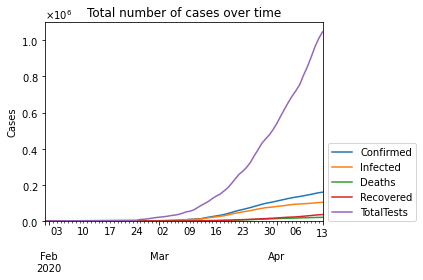

In [60]:
result = result.set_index('Date')
data_cols_all += ['TotalTests']
model.line_plot(result[data_cols_all], "Total number of cases over time")

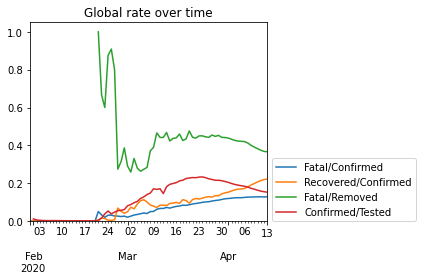

In [61]:
rate_cols = ['Fatal/Confirmed','Recovered/Confirmed','Fatal/Removed','Confirmed/Tested']

result[rate_cols[0]] = result["Deaths"] / result[data_cols].sum(axis=1)
result[rate_cols[1]] = result["Recovered"] / result[data_cols].sum(axis=1)
result[rate_cols[2]] = result["Deaths"] / (result["Deaths"] + result["Recovered"])
result[rate_cols[3]] = result["Confirmed"] /result["TotalTests"]

model.line_plot(result[rate_cols], "Global rate over time", ylabel="", math_scale=False)